<a href="https://colab.research.google.com/github/Raanank10/UK_Used_Car_Data/blob/main/100000_UK_Used_Car_Data_set_regression_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# General tools
import numpy as np
import scipy as sp
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances

# For the tree visualization
import pydot
from IPython.display import Image, display
from sklearn.externals.six import StringIO

# For scoring
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_squared_error as mse

# For validation
from sklearn.model_selection import train_test_split as split

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## Get the Data

In [25]:
url = 'https://raw.githubusercontent.com/Raanank10/UK_Used_Car_Data/main/toyota.csv'

df_Toyota = pd.read_csv(url, index_col=0)
df_Toyota.head()

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
model,,,,,,,,
GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [18]:
df_Toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81733 entries, 0 to 81732
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   <!DOCTYPE html>  81733 non-null  object
dtypes: object(1)
memory usage: 638.7+ KB


In [4]:
df_Toyota.shape

(6738, 9)

## Cleaning

In [5]:
df_Toyota.fuelType.value_counts()

Petrol    4087
Hybrid    2043
Diesel     503
Other      105
Name: fuelType, dtype: int64

In [6]:
df_Toyota.transmission.value_counts()

Manual       3826
Automatic    2657
Semi-Auto     254
Other           1
Name: transmission, dtype: int64

In [7]:
df_Toyota.model.value_counts()

 Yaris            2122
 Aygo             1961
 Auris             712
 C-HR              479
 RAV4              473
 Corolla           267
 Prius             232
 Avensis           115
 Verso             114
 Hilux              86
 GT86               73
 Land Cruiser       51
 PROACE VERSO       15
 Supra              12
 Camry              11
 IQ                  8
 Urban Cruiser       4
 Verso-S             3
Name: model, dtype: int64

In [8]:
df_Toyota.year.value_counts()

2017    2019
2019    1286
2018    1015
2016     997
2015     525
2014     352
2013     204
2020     128
2012      42
2011      40
2009      29
2007      20
2008      19
2010      18
2005      12
2006      11
2004       7
2003       6
2002       4
1998       1
2001       1
1999       1
2000       1
Name: year, dtype: int64

In [9]:
df_Toyota.describe()

,year,price,mileage,tax,mpg,engineSize
count,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000,6738.000000
mean,2016.748145,12522.391066,22857.413921,94.697240,63.042223,1.471297
std,2.204062,6345.017587,19125.464147,73.880776,15.836710,0.436159
min,1998.000000,850.000000,2.000000,0.000000,2.800000,0.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18513.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31063.750000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


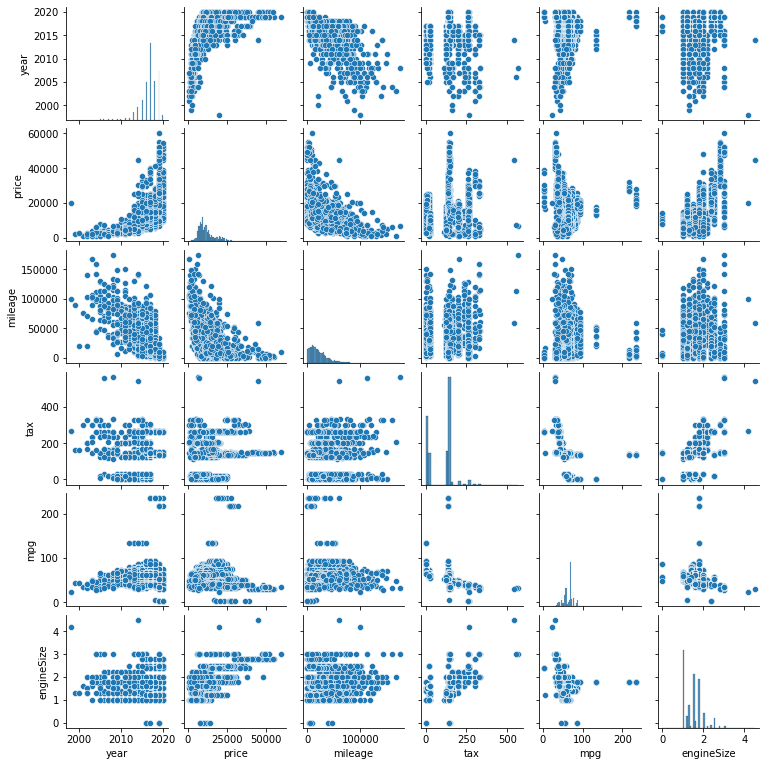

In [10]:
df_Toyota_num = df_Toyota.select_dtypes(include=np.number)
sns.pairplot(df_Toyota_num, height=1.8)

In [11]:
df_Toyota.corr()

,year,price,mileage,tax,mpg,engineSize
year,1.000000,0.420959,-0.727749,0.283455,-0.020607,-0.045567
price,0.420959,1.000000,-0.297936,0.214498,-0.039910,0.727592
mileage,-0.727749,-0.297936,1.000000,-0.205285,0.044889,0.182615
tax,0.283455,0.214498,-0.205285,1.000000,-0.430292,0.155727
mpg,-0.020607,-0.039910,0.044889,-0.430292,1.000000,-0.106868
engineSize,-0.045567,0.727592,0.182615,0.155727,-0.106868,1.000000


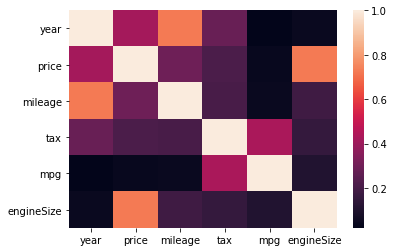

In [12]:
sns.heatmap(df_Toyota.corr().abs())